<a href="https://colab.research.google.com/github/Biyani404198/OCR-Sanskrit-Text-Detection-and-Extraction/blob/main/OCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# OCR Sanskrit Text Detection and Extraction

Problem Statement: To create bounding boxes for each line in the Sanskrit text that is provided as a pdf. After the bounding box is created for the entire line (and not the words), save each line in separate jpg files.

Additionally, save the coordinates of the bounding box in a JSON
format as shown below:

{
"box1": {
"top_left": [0, 0],
"top_right": [0, 10],
"bottom_left": [10, 0],
"bottom_right": [10, 10]
},
"box2": {
       ....
}
}

## Installation:

In [2]:
# install pypgfium2
!pip install "pypdfium2==4"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 39.1 MB/s eta 0:00:00


In [3]:
# install pytesseract, tesseract-ocr, libtesseract-dev
!pip install pytesseract
!sudo apt install tesseract-ocr
!sudo apt install libtesseract-dev

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 8 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 0s (23.5 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debcon

## import libraries:

In [4]:
import os
import re
import json
import cv2
import numpy as np
import pandas as pd
import pypdfium2 as pdfium
import pytesseract
from pytesseract import Output
from PIL import Image
from IPython.display import Image, display
from google.colab.patches import cv2_imshow

## Pre-processing:

In [5]:
# converting each page of pdf to an image
filepath = "/content/Sanskrit_Text (1).pdf"
pdf = pdfium.PdfDocument(filepath)
# Render multiple pages concurrently
num_pages_to_render = 5
page_indices = [i for i in range(min(num_pages_to_render, len(pdf)))]
renderer = pdf.render(pdfium.PdfBitmap.to_pil, page_indices=page_indices)
for index, image in zip(page_indices, renderer):
    image.save(f"output_{index + 1:02d}.jpg")

In [9]:
# check the shape of the image
# Load the image
img = cv2.imread('output_05.jpg')
# Get the shape of the image
height, width, channels = img.shape
# Print the dimensions
print("Image Height:", height)
print("Image Width:", width)
print("Number of Channels:", channels)

Image Height: 792
Image Width: 612
Number of Channels: 3


In [627]:
# Preprocessing functions
# grayscaling the image
def get_grayscale(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply Adaptive Gaussian Thresholding
    binary = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 65, 7)
    return binary

# Rescaling
def rescale(image):
    # Define the scaling factor for resizing
    scaling_factor = 3.5
    # Resize the image
    enlarged_image = cv2.resize(image, None, fx = scaling_factor, fy = scaling_factor, interpolation = cv2.INTER_LINEAR)
    return enlarged_image

# noise removal
def remove_noise(image):
    return cv2.medianBlur(image,5)

# perform all the preprocessing steps
def preprocess(image):
    enlarged = rescale(image)
    gray = get_grayscale(enlarged)
    noise = remove_noise(gray)
    return noise

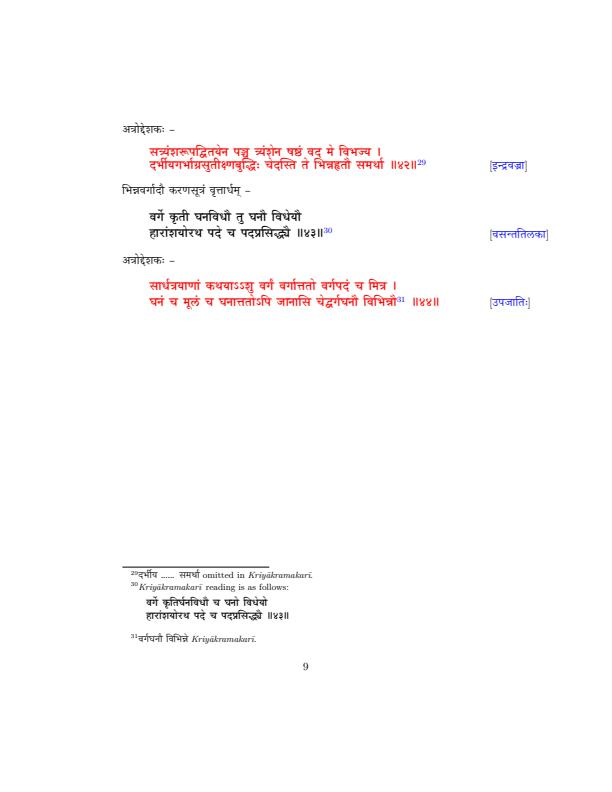

In [628]:
# Display the image
image_path = "output_01.jpg"
img = cv2.imread(image_path)
cv2_imshow(img)
cv2.waitKey(0)
cv2.destroyAllWindows()

## OCR:

In [630]:
# Function to create a folder
def create_folder(folder_path):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

# Function to save bounding box coordinates in a JSON format
def save_json(json_data, file_path):
    with open(file_path, 'w') as json_file:
        json.dump(json_data, json_file, indent=4)

In [640]:
# regex pattern
patt = '[^a-zA-Z0-9]+'

# combine boxes that belong to the same line and return an iterator of the combined lines
def lineup(boxes):
    linebox = None
    for _, box in boxes.iterrows():
        if linebox is None: linebox = box           # first line begins
        elif box.top <= linebox.top+linebox.height: # box in same line
            linebox.top = min(linebox.top, box.top)
            linebox.width = box.left+box.width-linebox.left
            linebox.height = max(linebox.top+linebox.height, box.top+box.height)-linebox.top
            linebox.text += ' '+box.text
        else:                                       # box in new line
            yield linebox
            linebox = box                           # new line begins
    yield linebox                                   # return last line

# function to processes each box, extracts its coordinates, and plots a box on the image
# and save each line seperately as .jpg
def plot_boxes(img, boxes, page_index, output_folder):
    boxes_dict = {}
    i = 0
    for _, b in boxes.iterrows():
        if b['text'].strip() != '':
            i += 1
            x, y, w, h = int(b['left']), int(b['top']), int(b['width']), int(b['height'])
            boxes_dict[f"box{i}"] = {
                "top_left": [x, y],
                "top_right": [x + w, y],
                "bottom_left": [x, y + h],
                "bottom_right": [x + w, y + h]
            }
            result = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 1)
            # Save each line as a separate JPG file
            line_image = img[y:y + h, x:x + w]
            output_file = os.path.join(output_folder, f"line_{i}.jpg")
            cv2.imwrite(output_file, line_image)
    cv2.imwrite(f'p{page_index}.jpg', result)
    return boxes_dict

In [ ]:
# getting the sanskrit train deta for tesseract
!wget https://github.com/tesseract-ocr/tessdata/raw/main/san.traineddata
!mv san.traineddata /usr/share/tesseract-ocr/4.00/tessdata/

In [ ]:
image_names = ["output_01.jpg", "output_02.jpg", "output_03.jpg", "output_04.jpg", "output_05.jpg"]

for page_index, image_name in enumerate(image_names):
    # Load the image
    page_image_path = os.path.join("/content/", image_name)
    img = cv2.imread(page_image_path)

    # Preprocess the image
    preprocessed = preprocess(img)

    # Use OCR to get bounding boxes and text
    boxes = pytesseract.image_to_data(preprocessed, lang="eng+san", output_type=Output.DICT)
    boxes = pd.DataFrame(boxes)
    boxes['text'].replace('', np.nan, inplace=True)
    boxes = boxes.dropna(subset=['text'])

    # Group boxes that belong to the same line
    lineboxes = pd.DataFrame.from_records(lineup(boxes))

    # Create a folder for each page to store the output images and JSON file
    page_output_folder = f"/content/page{page_index + 1}"
    create_folder(page_output_folder)

    # Save each line as separate JPG files and get bounding box coordinates
    page_boxes_dict = plot_boxes(preprocessed, lineboxes, page_index, page_output_folder)

    # Save bounding box coordinates in JSON format
    json_output_file = f"page_{page_index + 1}_boxes.json"
    json_output_path = os.path.join(page_output_folder, json_output_file)
    save_json(page_boxes_dict, json_output_path)

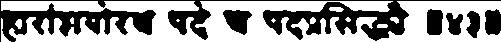

In [652]:
# Display image with single line
image_path = '/content/page_1/line_11.jpg'
img = cv2.imread(image_path)
cv2_imshow(img)
cv2.waitKey(0)
cv2.destroyAllWindows()

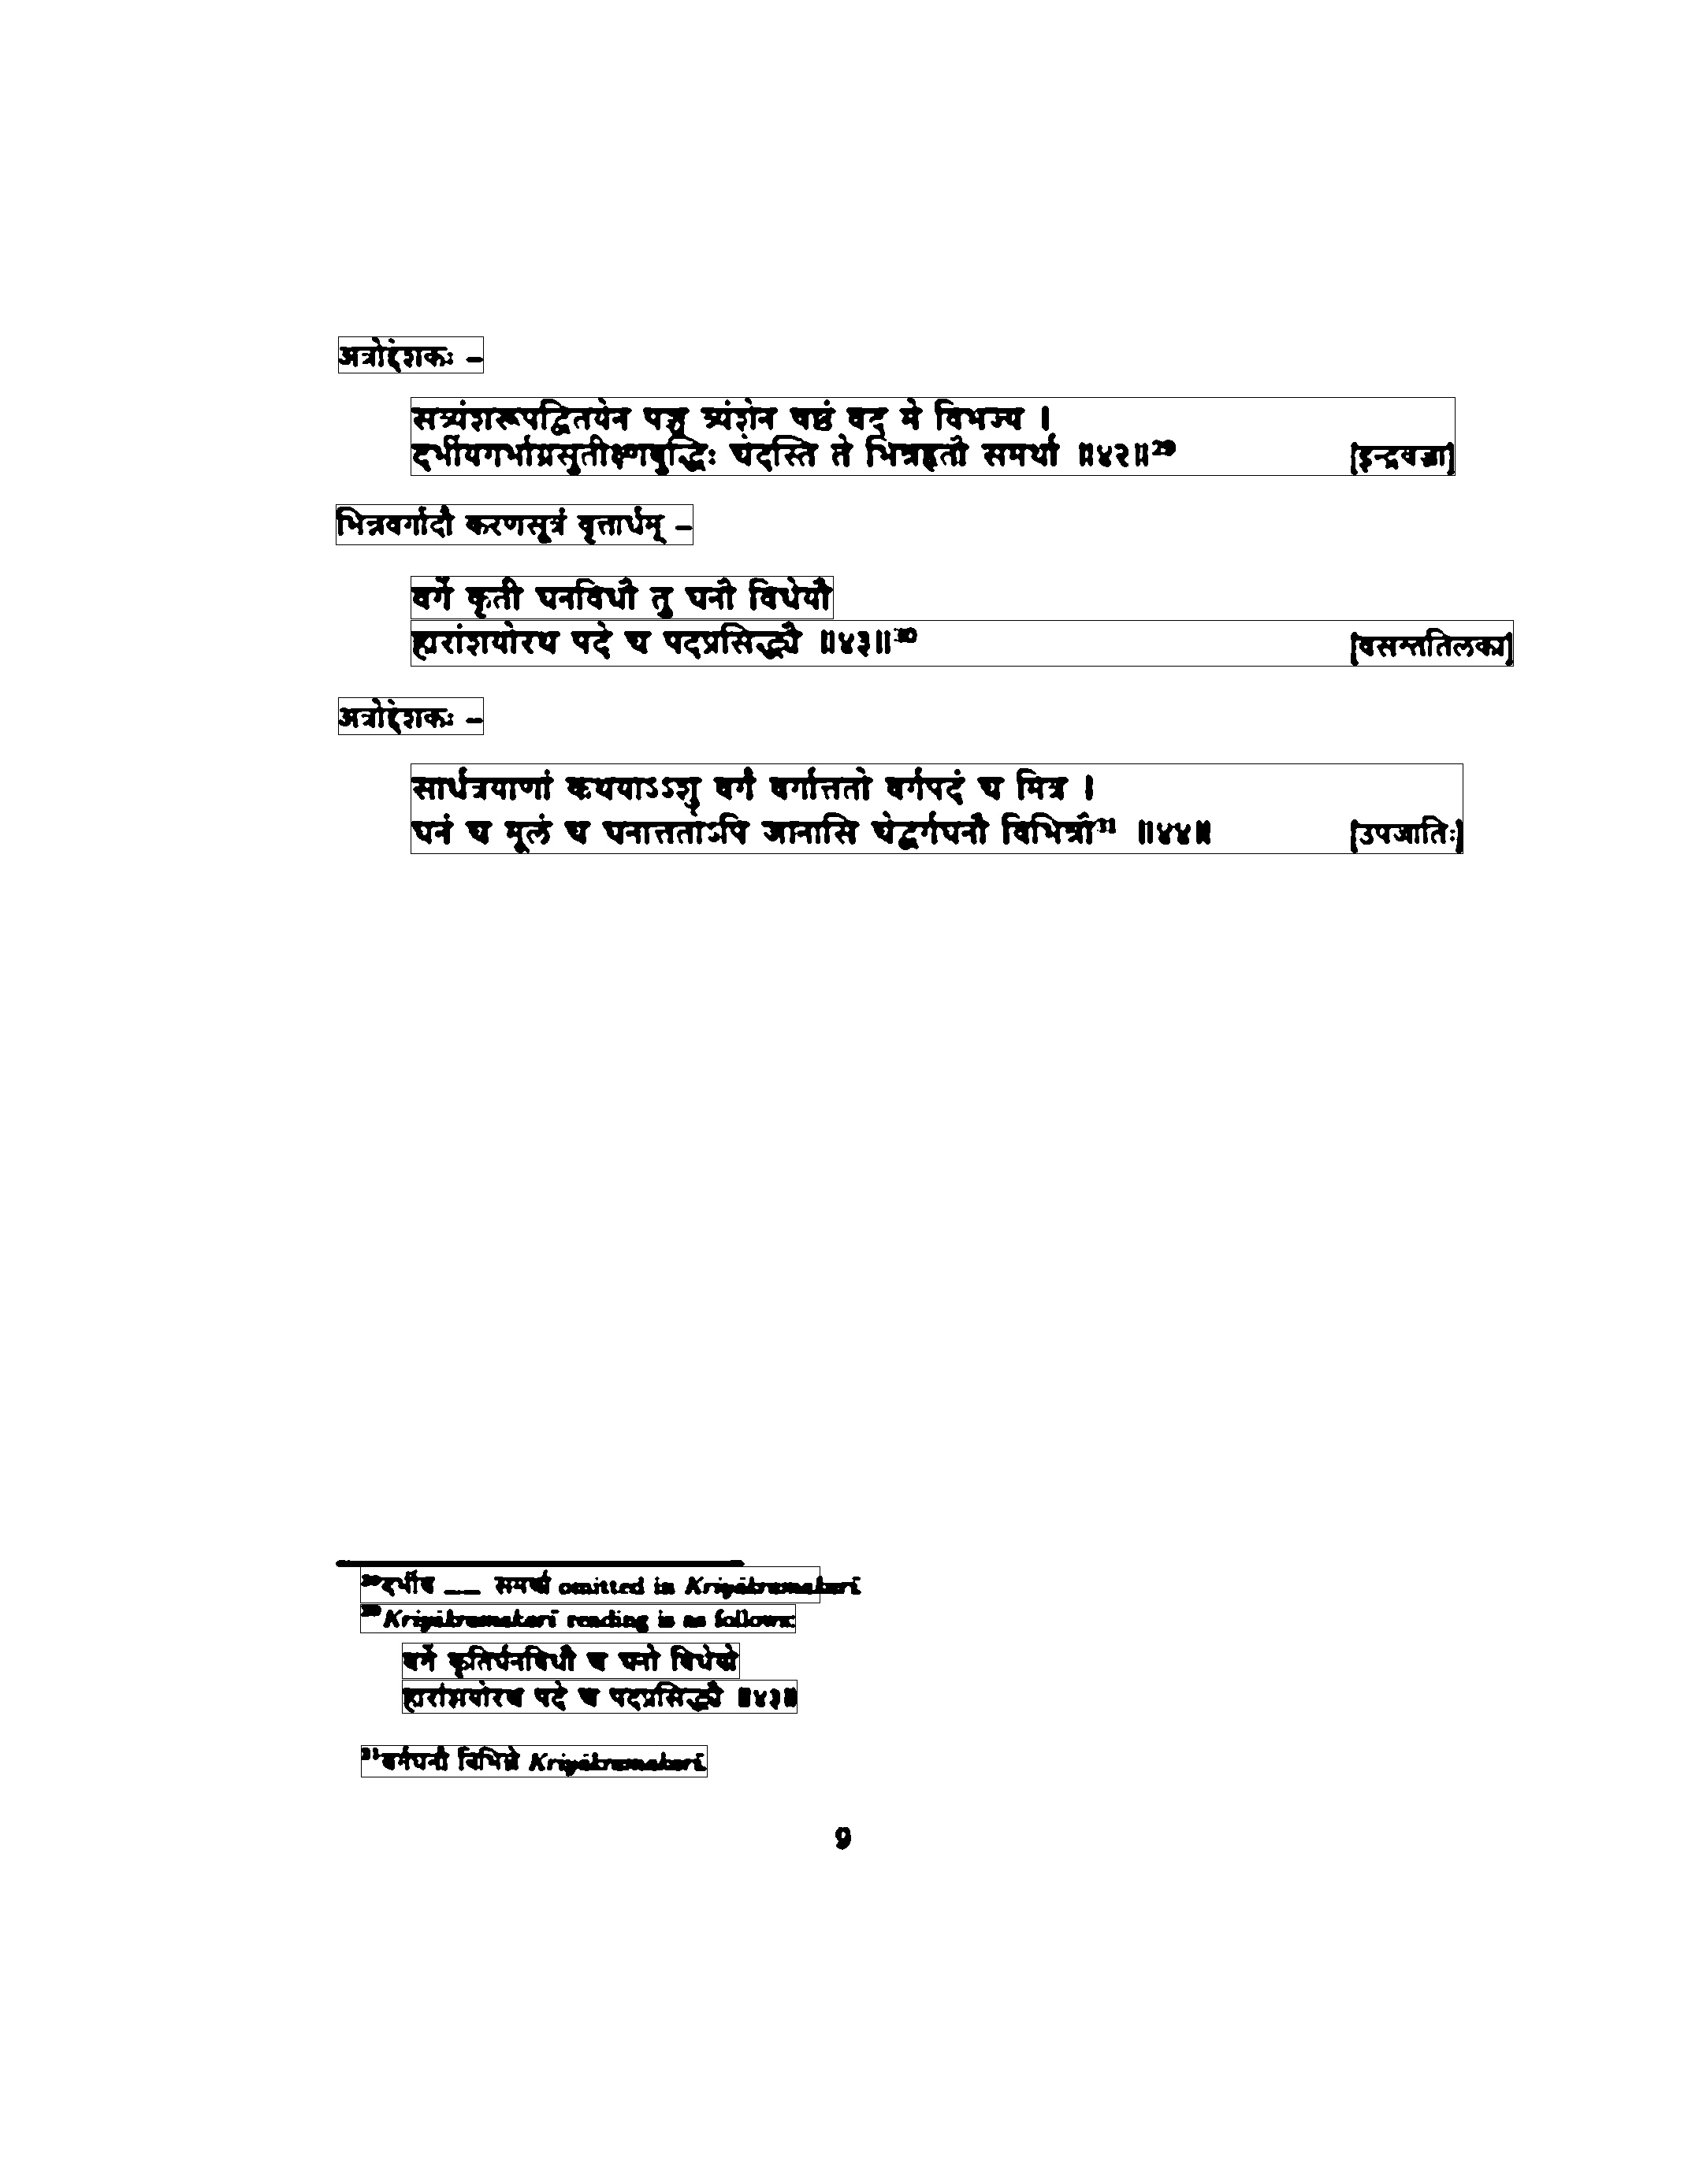

In [651]:
# Display image with bounding boxes
image_path = 'p0.jpg'
img = cv2.imread(image_path)
cv2_imshow(img)
cv2.waitKey(0)
cv2.destroyAllWindows()